In [1]:
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import KernelPCA



from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE




/var/folders/d9/x_bnq71n58lbk4_znq_twz6h0000gn/T/ipykernel_31327/487060219.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  water_market_data = pd.read_csv('./data/ALL_water_share_trading.csv', parse_dates=['Application Creation Date'], nrows=500)


     Status Application Creation Date Approved / Refused Date  \
0  Recorded                2013-12-07              24/07/2013   
1  Recorded                2020-06-01              09/01/2020   
2  Recorded                2009-04-30              13/07/2009   
3  Recorded                2018-04-13              26/04/2018   
4  Recorded                2022-09-09              28/09/2022   

  Recorded / Rejected Date Water Share ID Water System Source Reliability  \
0               23/08/2013      WEE****24            Goulburn        High   
1               10/03/2020      WEE****26              Murray        High   
2               11/09/2009      WEE****80            Goulburn         Low   
3               01/05/2018      WEE****36            Goulburn        High   
4               13/10/2022      WEE****71              Murray        High   

           Trading Zone Source Seller Water Authority  \
0          1A Greater Goulburn  Goulburn-Murray Water   
1  7 VIC Murray - Barmah to SA  

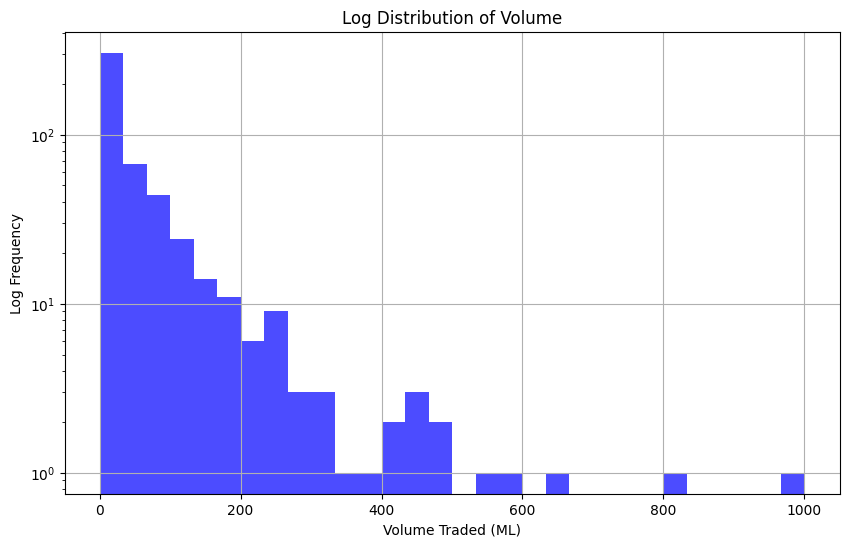

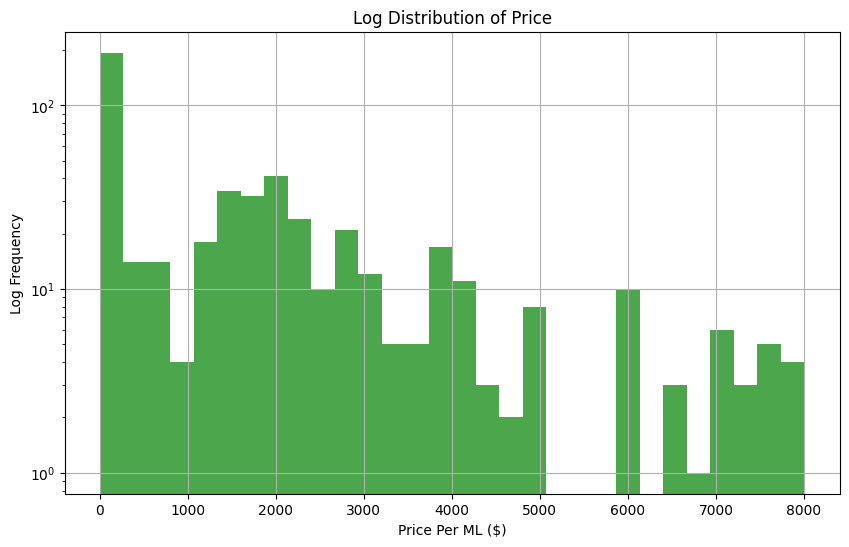

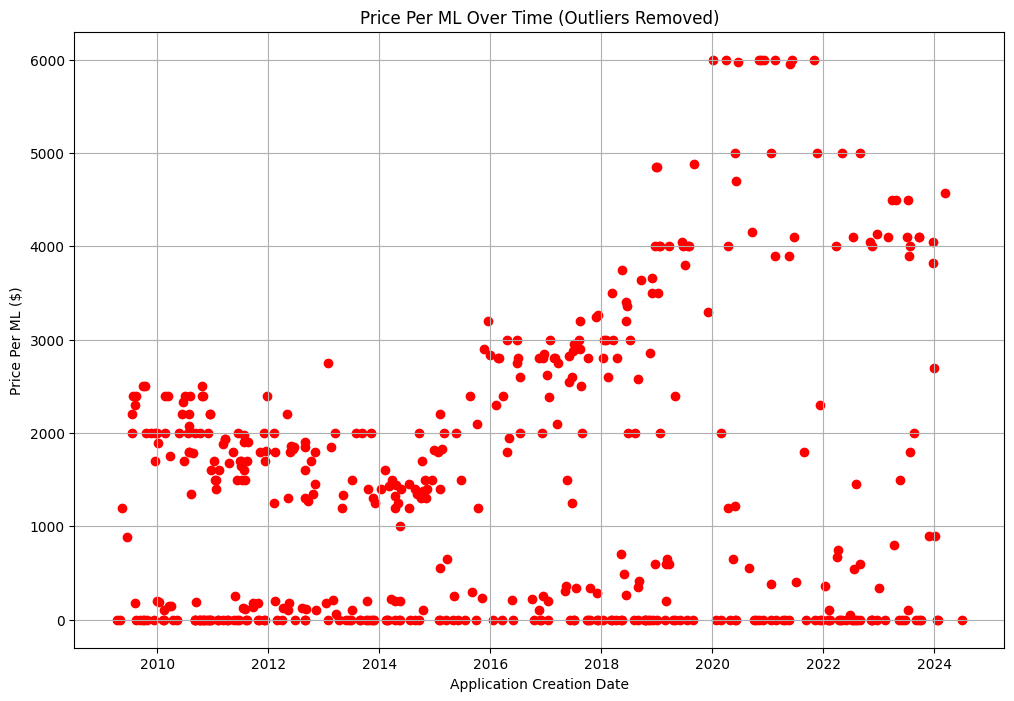

In [2]:
# Load SP500 and US macroeconomic data from CSV files
water_market_data = pd.read_csv('./data/ALL_water_share_trading.csv', parse_dates=['Application Creation Date'], nrows=500)

water_market_data = water_market_data.dropna()

# Check the first few rows of the data
print(water_market_data.head())

# Summary statistics for the numerical data
print(water_market_data.describe())

# Plotting the log distribution of the 'Volume' column
plt.figure(figsize=(10, 6))
plt.hist(water_market_data['Volume Traded (ML)'], bins=30, color='blue', alpha=0.7, log=True)
plt.title('Log Distribution of Volume')
plt.xlabel('Volume Traded (ML)')
plt.ylabel('Log Frequency')
plt.grid(True)
plt.show()

# Plotting the log distribution of the 'Price' column
plt.figure(figsize=(10, 6))
plt.hist(water_market_data['Price Per ML ($)'], bins=30, color='green', alpha=0.7, log=True)
plt.title('Log Distribution of Price')
plt.xlabel('Price Per ML ($)')
plt.ylabel('Log Frequency')
plt.grid(True)
plt.show()


# Plotting the 'Price Per ML ($)' over time using a scatter plot after removing outliers
plt.figure(figsize=(12, 8))
# Calculate the interquartile range to determine outliers
Q1 = water_market_data['Price Per ML ($)'].quantile(0.25)
Q3 = water_market_data['Price Per ML ($)'].quantile(0.75)
IQR = Q3 - Q1
# Filter out the outliers
filtered_data = water_market_data[(water_market_data['Price Per ML ($)'] >= (Q1 - 1.5 * IQR)) & (water_market_data['Price Per ML ($)'] <= (Q3 + 1.5 * IQR))]
plt.scatter(filtered_data['Application Creation Date'], filtered_data['Price Per ML ($)'], color='red')
plt.title('Price Per ML Over Time (Outliers Removed)')
plt.xlabel('Application Creation Date')
plt.ylabel('Price Per ML ($)')
plt.grid(True)
plt.show()


0    255
1    245
Name: Class, dtype: int64
Accuracy: 0.37
Confusion Matrix:
[[ 0 63]
 [ 0 37]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.37      1.00      0.54        37

    accuracy                           0.37       100
   macro avg       0.18      0.50      0.27       100
weighted avg       0.14      0.37      0.20       100



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


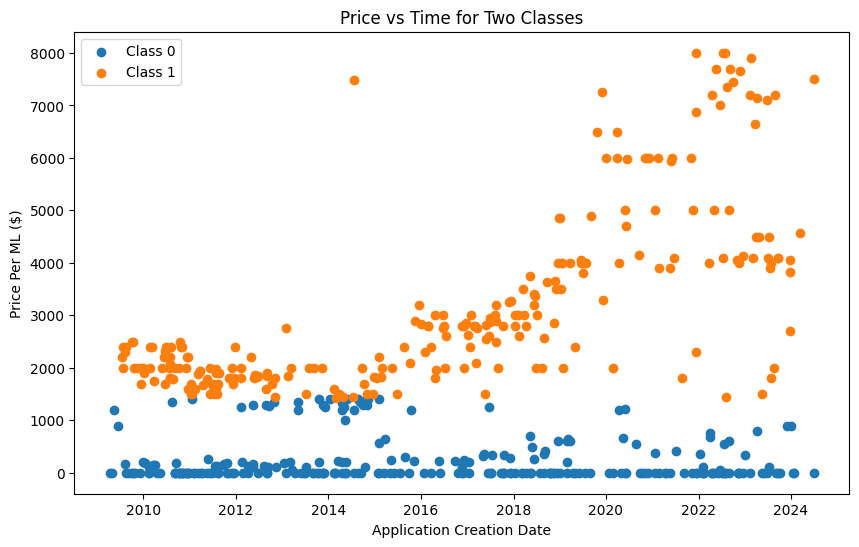

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Calculate the median of the 'Price Per ML ($)' column
median_price = water_market_data['Price Per ML ($)'].median()

# Create two classes: 0 for prices below or equal to the median, 1 for prices above the median
water_market_data['Class'] = (water_market_data['Price Per ML ($)'] > median_price).astype(int)

# Check the distribution of the new classes
print(water_market_data['Class'].value_counts())

# Assuming 'Class' is the target variable and 'Volume Traded (ML)' is the feature
X = water_market_data[['Volume Traded (ML)']]
y = water_market_data['Class']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying nonlinear SVM classification with a polynomial kernel
svm_classifier = SVC(kernel='poly')
svm_classifier.fit(X_train_scaled, y_train)

# Predicting the test set results
y_pred = svm_classifier.predict(X_test_scaled)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

import matplotlib.pyplot as plt

# Convert 'Application Creation Date' to datetime if not already done
if not pd.api.types.is_datetime64_any_dtype(water_market_data['Application Creation Date']):
    water_market_data['Application Creation Date'] = pd.to_datetime(water_market_data['Application Creation Date'], dayfirst=True)

# Plotting price vs time for the two classes using scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
for label, group in water_market_data.groupby('Class'):
    ax.scatter(group['Application Creation Date'], group['Price Per ML ($)'], label=f'Class {label}')
ax.set_title('Price vs Time for Two Classes')
ax.set_xlabel('Application Creation Date')
ax.set_ylabel('Price Per ML ($)')
ax.legend()
plt.show()
